In [9]:
require(nnet)
require(car)

Loading required package: car

Loading required package: carData



In [1]:
dat <- read.csv("admissions.csv")
head(dat)

,provnum,died,white,los,age80,age,admission
,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,30001,0,1,4,0,4,Elective
2,30001,0,1,9,0,4,Elective
3,30001,1,1,3,1,7,Elective
4,30001,0,1,9,0,6,Elective
5,30001,1,1,1,1,7,Elective
6,30001,1,1,4,0,5,Elective


In this practical we are going to investigate how the probability of type of hospital admission changes given some
covariates using the admissions data by

In [19]:
library(ggplot2)
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

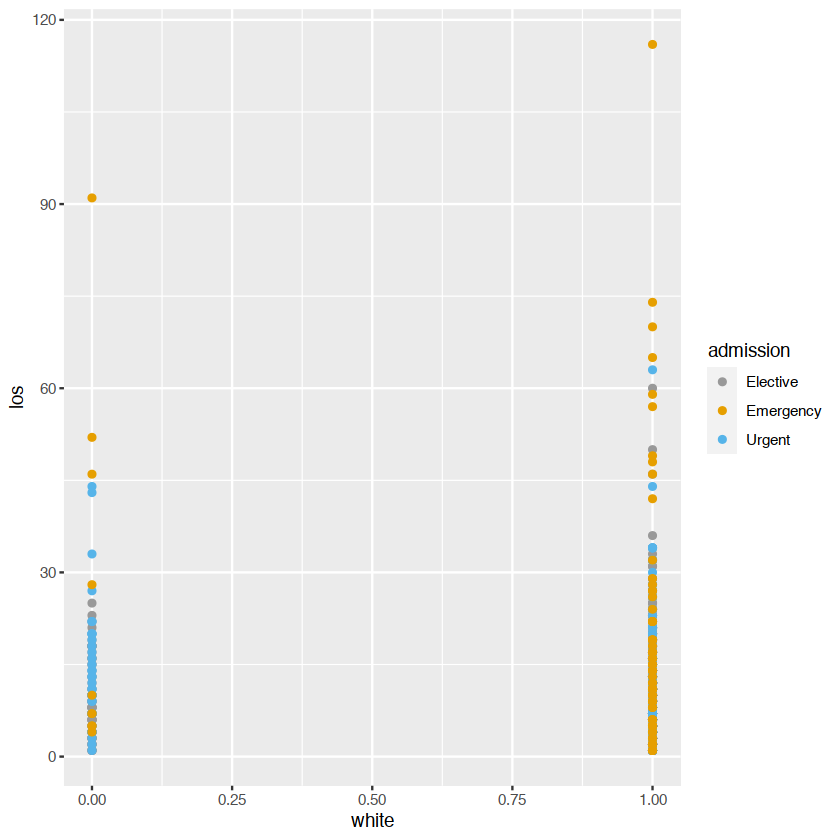

In [24]:
ggplot(dat, aes(white, los, colour=admission)) + geom_point() + scale_colour_manual(values=cbPalette)

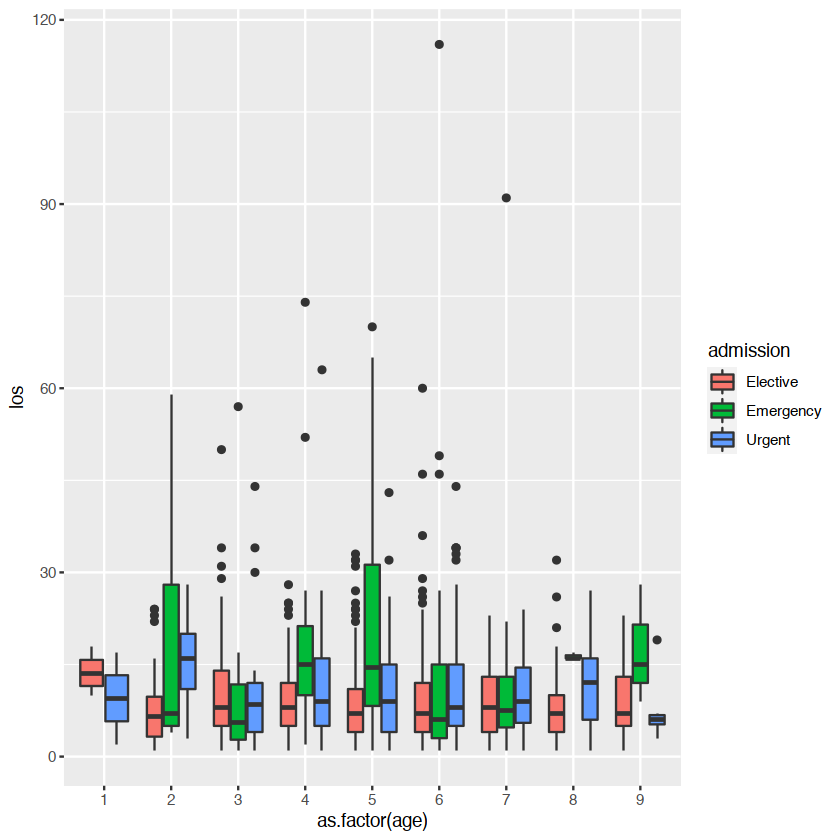

In [43]:
ggplot(dat, aes(as.factor(age), los, fill = admission)) + geom_boxplot()

In [54]:
table(dat$white) # disproportionate number of white people compared to black. Only 10% non-white people


   0    1 
 127 1368 

In [63]:
prop.table(table(dat$admission)) # dispproportionate number of cases in each category


  Elective  Emergency     Urgent 
0.75852843 0.06421405 0.17725753 

In [65]:
table(dat$admission, dat$white)

           
               0    1
  Elective    80 1054
  Emergency   10   86
  Urgent      37  228

In [74]:
non_white = dat[dat$white == 0,]
prop.table(table(non_white$admission))
white = dat[dat$white == 1, ]
prop.table(table(white$admission))


  Elective  Emergency     Urgent 
0.62992126 0.07874016 0.29133858 


 Elective Emergency    Urgent 
0.7704678 0.0628655 0.1666667 

In [2]:
table(dat$died)


  0   1 
982 513 

In [4]:
head(dat)

,provnum,died,white,los,age80,age,admission
,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,30001,0,1,4,0,4,Elective
2,30001,0,1,9,0,4,Elective
3,30001,1,1,3,1,7,Elective
4,30001,0,1,9,0,6,Elective
5,30001,1,1,1,1,7,Elective
6,30001,1,1,4,0,5,Elective


In [41]:
levels(as.factor(dat$admission))

[1] "Elective"  "Emergency" "Urgent"

### Model by backwards removal

vif manually on 2 glm models

In [83]:
model<-multinom(admission ~ as.factor(died) + as.factor(white) + los + as.factor(age),dat=dat)
labels = rownames(coefficients(model))
ref = setdiff(model$lab,labels)
print(t(sapply(labels,function(i){
       dat = dat
       dat$Admission = as.numeric(dat$admission == i)
       vif(glm(Admission ~ as.factor(died) + as.factor(white) + los + as.factor(age), data=dat,family="binomial"))
})))

# weights:  39 (24 variable)
initial  value 1642.425372 
iter  10 value 1014.997824
iter  20 value 976.611848
iter  30 value 975.609193
iter  40 value 975.339192
final  value 975.336370 
converged
              [,1]     [,2]     [,3]     [,4] [,5] [,6] [,7] [,8]     [,9]
Emergency 1.049889 1.081559 1.038056 1.118861    1    1    1    8 1.024641
Urgent    1.037302 1.130156 1.017208 1.154036    1    1    1    8 1.018480
             [,10]    [,11]    [,12]
Emergency 1.039980 1.018850 1.007044
Urgent    1.063088 1.008567 1.008994


In [85]:
# Fit model with given parameters
model<-multinom(admission ~ as.factor(died) + as.factor(white) + los + as.factor(age),dat=dat)
summary(model)
print(Anova(model)) # anova shows that age is not significant at 5% level,
#no difference between the full model and the restricted model. p-value 0.7
#remove age as it's not significant to predict the admission type
model = update(model, .~.-as.factor(age))
print(Anova(model)) # everything is significant now
AIC(model)

# weights:  39 (24 variable)
initial  value 1642.425372 
iter  10 value 1014.997824
iter  20 value 976.611848
iter  30 value 975.609193
iter  40 value 975.339192
final  value 975.336370 
converged


Call:
multinom(formula = admission ~ as.factor(died) + as.factor(white) + 
    los + as.factor(age), data = dat)

Coefficients:
          (Intercept) as.factor(died)1 as.factor(white)1        los
Emergency  -14.480028        0.8843423        -0.2659818 0.08229547
Urgent      -1.009585        0.4251682        -0.8228976 0.04041129
          as.factor(age)2 as.factor(age)3 as.factor(age)4 as.factor(age)5
Emergency      11.1642071      10.5855066     11.23116222      11.0395100
Urgent         -0.7155955      -0.6092481      0.01959556      -0.2118779
          as.factor(age)6 as.factor(age)7 as.factor(age)8 as.factor(age)9
Emergency      10.8690510      10.8326677      10.2307707      10.9427343
Urgent         -0.2038504      -0.3805863      -0.2507813      -0.6419387

Std. Errors:
          (Intercept) as.factor(died)1 as.factor(white)1         los
Emergency   0.3788892        0.2296903         0.3966978 0.010027505
Urgent      0.8872350        0.1463057         0.2307836 0.008577103
   

Analysis of Deviance Table (Type II tests)

Response: admission
                 LR Chisq Df Pr(>Chisq)    
as.factor(died)    20.076  2   4.37e-05 ***
as.factor(white)   11.918  2   0.002582 ** 
los                80.773  2  < 2.2e-16 ***
as.factor(age)     13.733 16   0.618609    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
# weights:  15 (8 variable)
initial  value 1642.425372 
iter  10 value 994.061612
final  value 982.202790 
converged
Analysis of Deviance Table (Type II tests)

Response: admission
                 LR Chisq Df Pr(>Chisq)    
as.factor(died)    19.519  2  5.774e-05 ***
as.factor(white)   10.888  2   0.004323 ** 
los                81.637  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


[1] 1980.406

### Model using step function
Fit the model without the collinear (race) variable and perform both backward and forward model selection.

In [86]:
step_model = multinom(admission ~ as.factor(died) + as.factor(white) + los + as.factor(age), dat=dat)
step_model = step(step_model, direction="both")
summary(step_model) # this is the same model as the one done by just backward, gives the same AIC.

# weights:  39 (24 variable)
initial  value 1642.425372 
iter  10 value 1014.997824
iter  20 value 976.611848
iter  30 value 975.609193
iter  40 value 975.339192
final  value 975.336370 
converged
Start:  AIC=1998.67
admission ~ as.factor(died) + as.factor(white) + los + as.factor(age)

trying - as.factor(died) 
# weights:  36 (22 variable)
initial  value 1642.425372 
iter  10 value 1056.004454
iter  20 value 986.057711
iter  30 value 985.571529
iter  40 value 985.375392
final  value 985.374438 
converged
trying - as.factor(white) 
# weights:  36 (22 variable)
initial  value 1642.425372 
iter  10 value 989.985418
iter  20 value 981.887943
iter  30 value 981.485666
iter  40 value 981.295989
final  value 981.295486 
converged
trying - los 
# weights:  36 (22 variable)
initial  value 1642.425372 
iter  10 value 1044.090452
iter  20 value 1016.304322
iter  30 value 1015.893068
iter  40 value 1015.723903
final  value 1015.722809 
converged
trying - as.factor(age) 
# weights:  15 (8 variable

Call:
multinom(formula = admission ~ as.factor(died) + as.factor(white) + 
    los, data = dat)

Coefficients:
          (Intercept) as.factor(died)1 as.factor(white)1        los
Emergency   -3.523321        0.8470658        -0.2778606 0.08230527
Urgent      -1.342438        0.4232942        -0.7381674 0.04069428

Std. Errors:
          (Intercept) as.factor(died)1 as.factor(white)1         los
Emergency   0.4092895        0.2259073         0.3808220 0.009941462
Urgent      0.2303212        0.1440877         0.2154271 0.008499039

Residual Deviance: 1964.406 
AIC: 1980.406 

### dredge selection (all models)

In [89]:
require(MuMIn)
options(na.action='na.fail')
dredge_model = multinom(admission ~ as.factor(died) + as.factor(white) + los + as.factor(age), dat=dat)
head(dredge(dredge_model))

# weights:  39 (24 variable)
initial  value 1642.425372 
iter  10 value 1014.997824
iter  20 value 976.611848
iter  30 value 975.609193
iter  40 value 975.339192
final  value 975.336370 
converged


Fixed term is "(Intercept)"



# weights:  6 (2 variable)
initial  value 1642.425372 
final  value 1035.470638 
converged
# weights:  30 (18 variable)
initial  value 1642.425372 
iter  10 value 1052.226704
iter  20 value 1029.717241
iter  30 value 1029.366142
final  value 1029.306327 
converged
# weights:  9 (4 variable)
initial  value 1642.425372 
iter  10 value 1029.610778
final  value 1029.609794 
converged
# weights:  33 (20 variable)
initial  value 1642.425372 
iter  10 value 1058.433771
iter  20 value 1023.328403
iter  30 value 1023.017550
iter  40 value 1022.882664
final  value 1022.882545 
converged
# weights:  9 (4 variable)
initial  value 1642.425372 
iter  10 value 1029.430254
final  value 1029.320412 
converged
# weights:  33 (20 variable)
initial  value 1642.425372 
iter  10 value 1047.790175
iter  20 value 1022.876507
iter  30 value 1022.409827
iter  40 value 1022.344716
final  value 1022.344532 
converged
# weights:  12 (6 variable)
initial  value 1642.425372 
iter  10 value 1039.617683
iter  20 value

,(Intercept),as.factor(age),as.factor(died),as.factor(white),los,df,logLik,AICc,delta,weight
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<mdl.wght>
15,+,NA,+,+,+,8,-982.2028,1980.502,0.000000,9.679360e-01
11,+,NA,+,NA,+,6,-987.6467,1987.350,6.847278,3.154853e-02
13,+,NA,NA,+,+,6,-991.9624,1995.981,15.478738,4.213872e-04
16,+,+,+,+,+,24,-975.3364,1999.489,18.986583,7.293945e-05
9,+,NA,NA,NA,+,4,-997.0431,2002.113,21.610625,1.964080e-05
12,+,+,+,NA,+,22,-981.2955,2007.278,26.775987,1.484277e-06


### Model interpretation

In [99]:
coef(model)

,(Intercept),as.factor(died)1,as.factor(white)1,los
Emergency,-3.523321,0.8470658,-0.2778606,0.08230527
Urgent,-1.342438,0.4232942,-0.7381674,0.04069428


In [103]:
unique(dat$admission)
data.frame(
    Admission=c("Emergency", "Urgent"),
    OddDifference = c(round(exp(-3.523321), 2), round(exp(-1.342438),2))
)

[1] "Elective"  "Urgent"    "Emergency"

Admission,OddDifference
<chr>,<dbl>
Emergency,0.03
Urgent,0.26


Odds of Emergency vs Elective is 0.03. This means that the probability of being admitted as an emergency is equal to 3% of the probability of being admitted electively when the patient is alive and they are not white. 

Odds of Urgent vs Elective is 0.26. This means that the probability that the patient is admitted urgently is equal to the probability of being admitted electively times 0.26 when the patient leaves the hospital alive and they are not white. Or in other words, non-white patients that are still alive when they leave the hospital are 0.26 times less likely to be admitted urgently instead of electively. 

In [147]:
d = round(predict(model,newdata=data.frame(los=c(2,1), white=1, died=0),type="probs"), 2)
d
print(paste("Emergency", round(exp(log(d[1,2]/d[1,1]) - log(d[2,2]/d[2,1])), 2)))
print(paste("Urgent", round(exp(log(d[1,3]/d[1,1]) - log(d[2,3]/d[2,1])), 2)))

,Elective,Emergency,Urgent
1,0.86,0.02,0.12
2,0.87,0.02,0.11


[1] "Emergency 1.01"
[1] "Urgent 1.1"


When the patient is white and they left the hospital alive after day 2 instead of day 1, the odds of being admitted in an emergency rather than elective increase by 1.01 and the odds of being admitted urgently instead of electively increase by 1.1.

In [159]:
d = round(predict(model,newdata=data.frame(
    los=c(5b,5), 
    white=as.factor(1),
    died=c(as.factor(1), as.factor(0))),type="probs"), 2)
d
print(paste("Emergency odds", round(exp(log(d[1,2]/d[1,1]) - log(d[2,2]/d[2,1])), 2)))
print(paste("Urgent odds", round(exp(log(d[1,3]/d[1,1]) - log(d[2,3]/d[2,1])), 2)))

,Elective,Emergency,Urgent
1,0.71,0.08,0.20
2,0.81,0.04,0.15


[1] "Emergency odds 2.28"
[1] "Urgent odds 1.52"


When the patient is white and they stayed 5 days in the hospital, but left dead instead of alive, the odds of being admitted in an emergency are 2.2 times higher than the odds of being admitted electively. Additionally, when a white patient stayed for 5 days in the hospital but died instead of leaving alive, the odds of being admitted urgently are 1.53 times higher than the odds of being admitted electively.

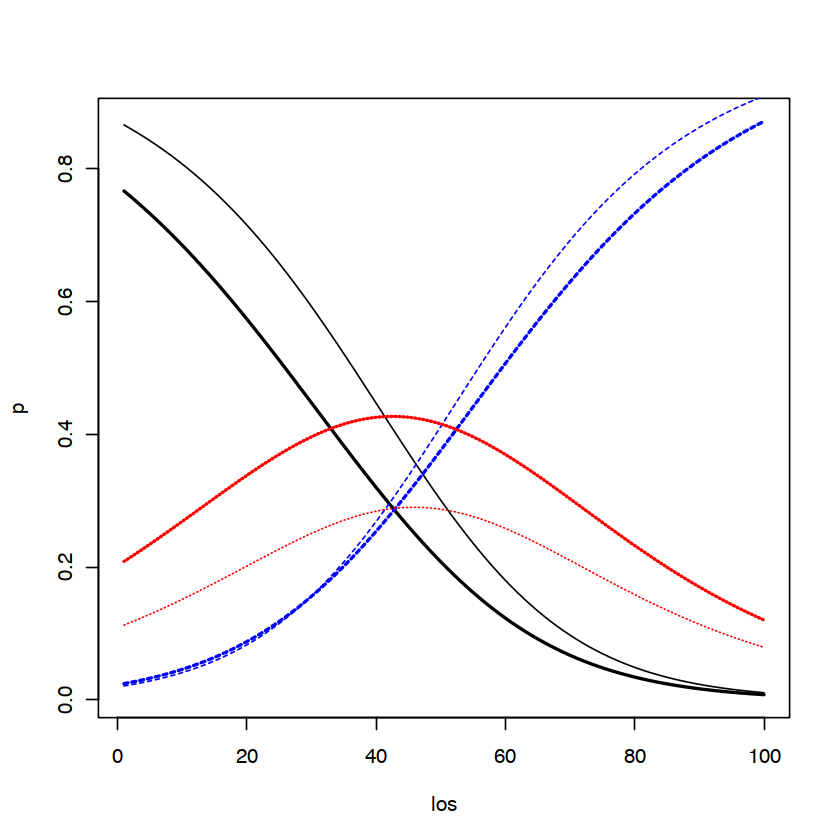

In [178]:
los<-1:100
pred_white<-predict(model,newdata=data.frame(white=as.factor(1), died=as.factor(0),los=los),type="probs")
pred_black<-predict(model,newdata=data.frame(white=as.factor(0), died=as.factor(0),los=los),type="probs")

plot(los,pred_white[,1],type="l",lty=1,ylim=range(pred),ylab="p") # elective decrease by length of stay
lines(los,pred_black[,1],lty=1, lwd=2) # emergency
lines(los,pred_white[,2],lty=2, col="blue") # emergency
lines(los,pred_black[,2],lty=2, col="blue", lwd="2") # emergency black
lines(los,pred_white[,3],lty=3, col="red") # urgent
lines(los,pred_black[,3],lty=3, col="red", lwd="2")